<a href="https://colab.research.google.com/github/maciejskorski/new_pll_trng/blob/main/TRNG_Dependency_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data



In [1]:
# update Python software - and restart the kernel when necessary
!pip install --upgrade statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# Download the zipped files from the shared internet link:
!curl -L "https://filesender.renater.fr/download.php?token=c4a56006-e8f9-4d78-9357-d4540b99e185&files_ids=17941252" --output data_v1.zip
!unzip data_v1.zip -d data_v1
!curl -L "https://filesender.renater.fr/download.php?token=76f39908-16e7-4b6b-b497-5849066c7641&files_ids=17983818" --output data_v2.zip
!unzip data_v2.zip -d data_v2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5838k  100 5838k    0     0   209k      0  0:00:27  0:00:27 --:--:--  233k
Archive:  data_v1.zip
   creating: data_v1/220927_CVa2/
  inflating: data_v1/220927_CVa2/acq_20220927232404_cnt.bin  
  inflating: data_v1/220927_CVa2/acq_20220927232605_rng.bin  
  inflating: data_v1/220927_CVa2/acq_20220927232902_dff.bin  
  inflating: data_v1/220927_CVa2/Curve_CVa2.pdf  
  inflating: data_v1/220927_CVa2/log_20220927232404_cnt.txt  
  inflating: data_v1/220927_CVa2/log_20220927232605_rng.txt  
  inflating: data_v1/220927_CVa2/log_20220927232902_dff.txt  
   creating: data_v1/220928_CVa1/
  inflating: data_v1/220928_CVa1/acq_20220928101804_rng.bin  
  inflating: data_v1/220928_CVa1/acq_20220928102114_dff.bin  
  inflating: data_v1/220928_CVa1/acq_20220928102506_cnt.bin  
  inflating: data_v1/220928_CVa1/Curve_CVa1.pdf  
  inflating: da

# Analysis Module

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from IPython.display import display
from pathlib import Path
import logging

plt.rcParams['figure.figsize'] = (10,3)
logger = logging.getLogger('TRNG Analysis')
logger.setLevel(logging.INFO)


def get_bytes_data(fpath):
  with open(fpath,'rb') as f:
    bytes_data = f.read()
  bytes_data = pd.DataFrame(list(bytes_data),columns=['byte value'])
  bytes_data.index.name = 'time'
  return bytes_data

def analyze_series(fpath, nlags=10, alpha=0.05):
  logger.info(f'Doing {fpath}')
  bytes_data = get_bytes_data(fpath)

  fig,axs = plt.subplots(1,2,constrained_layout=True)
  # histogram
  ax = axs[0]
  sns.histplot(data=bytes_data,x='byte value',ax=ax,discrete=True)
  # time series
  ax = axs[1]
  sns.lineplot(data=bytes_data.loc[:1000],x='time',y='byte value',ax=ax)
  plt.show()
  # autocorelation
  fig,ax = plt.subplots(1,1,constrained_layout=True)
  fig = plot_acf(x=bytes_data, lags = nlags, fft=True, alpha=alpha, bartlett_confint=True, zero=False, adjusted=True, ax=ax, auto_ylims=True)
  ax.set(xlabel='Lag',ylabel='Corr')
  plt.show()
  # exact p-values for autocorrelation
  _,_,_,pvals = acf(
          x=bytes_data,
          nlags=nlags,
          alpha=alpha,
          fft=True,
          bartlett_confint=True,
          adjusted=True,
          qstat=True
  )
  pvals = {'lag':np.arange(1,nlags+1),'Ljung-Box Test p-val':pvals}
  pvals = pd.DataFrame(pvals)
  display(pvals)

# Results

Overall, I see strong negative correlation	😞.

In [3]:
import numpy
import scipy
path = 'data_v2/PR_Card_7/220928_CVa4/acq_20220928165458_cnt.bin'
x = np.fromfile(path,dtype='uint8')
scipy.stats.pearsonr(x[:-1],x[1:]) # small p-value means correlation! 

(-0.039759020081430105, 0.0)

## Experiment 1

### CVa1

Result: **autocorrelations present**.

Evidence: autorreations outside the expected intervals + strongly significant p-values in Ljung-Box test.

INFO:TRNG Analysis:Doing data_v1/220928_CVa1/acq_20220928102506_cnt.bin


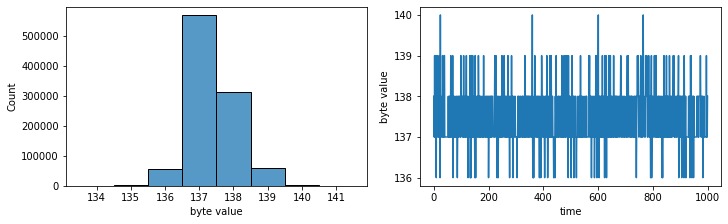

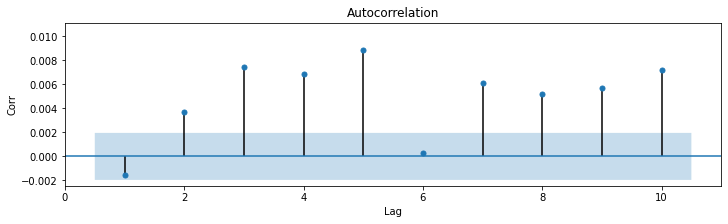

,lag,Ljung-Box Test p-val
0,1,1.130138e-01
1,2,3.194725e-04
2,3,2.367434e-15
3,4,1.041509e-24
4,5,7.375396e-41
5,6,4.677043e-40
6,7,3.834619e-47
7,8,4.367458e-52
8,9,3.421362e-58
9,10,1.711470e-68


In [4]:
from pathlib import Path

path = next(Path('data_v1').rglob('*CVa1*/*cnt.bin'))
analyze_series(path)
    

### CVa2

Result: **autocorrelations present**.

Evidence: autorreations outside the expected intervals + strongly significant p-values in Ljung-Box test.

INFO:TRNG Analysis:Doing data_v1/220927_CVa2/acq_20220927232404_cnt.bin


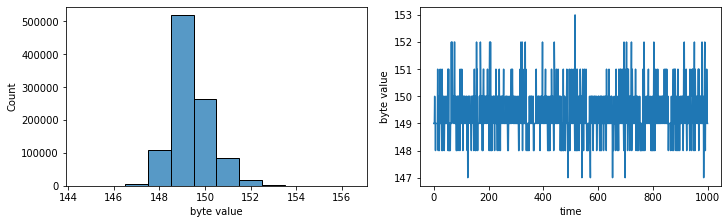

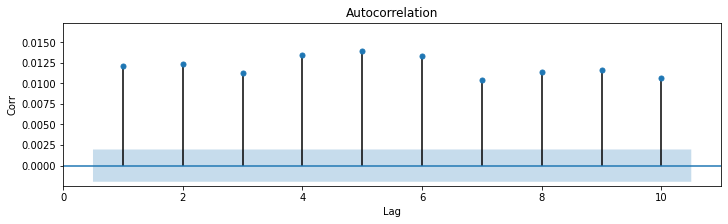

,lag,Ljung-Box Test p-val
0,1,9.929075e-34
1,2,1.806678e-65
2,3,1.512893e-91
3,4,1.701093e-129
4,5,4.476815e-170
5,6,2.445621e-207
6,7,2.075802e-229
7,8,1.857686e-256
8,9,2.413793e-284
9,10,1.213934e-307


In [5]:
path = next(Path('data_v1').rglob('*CVa2*/*cnt.bin'))
analyze_series(path)
    

### CVa4

Result: **autocorrelations present**.

Evidence: autorreations outside the expected intervals + strongly significant p-values in Ljung-Box test.

INFO:TRNG Analysis:Doing data_v1/220928_CVa4/acq_20220928104101_cnt.bin


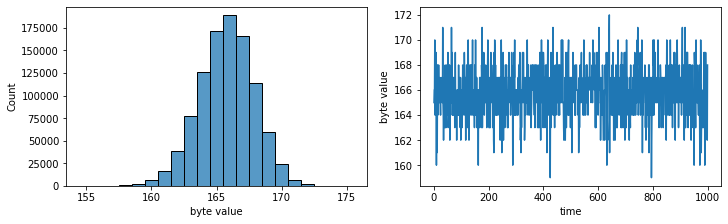

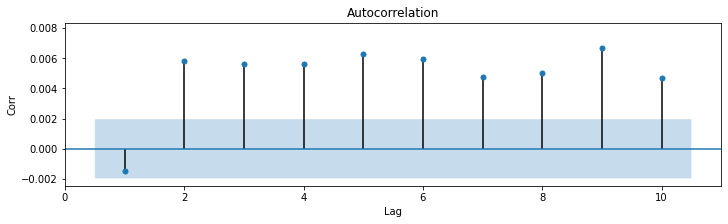

,lag,Ljung-Box Test p-val
0,1,1.413269e-01
1,2,1.524514e-08
2,3,1.244436e-14
3,4,1.479757e-20
4,5,4.232360e-28
5,6,7.744609e-35
6,7,7.952064e-39
7,8,2.319156e-43
8,9,5.096951e-52
9,10,7.519899e-56


In [6]:
path = next(Path('data_v1').rglob('*CVa4*/*cnt.bin'))
analyze_series(path)

## Experiment 2



### Card2 CVa1

**Strong correlations**, particularly between **two consecutive bits**.

INFO:TRNG Analysis:Doing data_v2/PR_Card_2/220928_CVa1/acq_20220928223624_cnt.bin


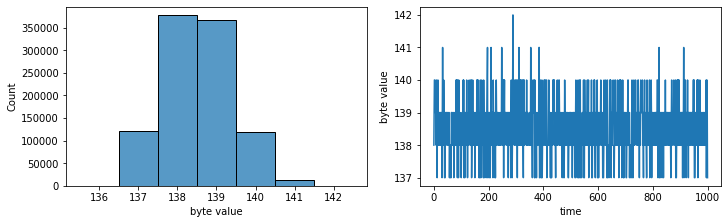

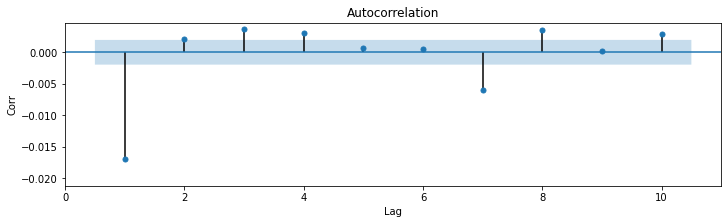

,lag,Ljung-Box Test p-val
0,1,1.915164e-64
1,2,4.747970e-64
2,3,6.069260e-66
3,4,5.853029e-67
4,5,4.489928e-66
5,6,3.359873e-65
6,7,7.497692e-72
7,8,1.288042e-73
8,9,8.791435e-73
9,10,1.159161e-73


In [7]:
path = next(Path('data_v2').rglob('PR_Card_2/*CVa1*/*cnt.bin'))
analyze_series(path)

### Card2 CVa2

**Strong correlations**, particularly between **two consecutive bits**.

INFO:TRNG Analysis:Doing data_v2/PR_Card_2/220928_CVa2/acq_20220928230941_cnt.bin


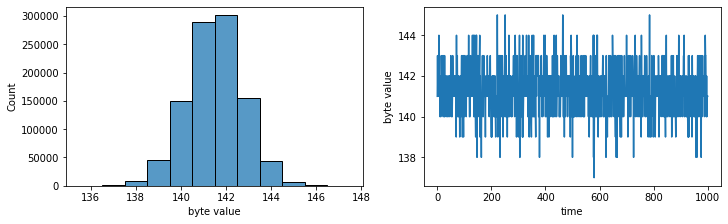

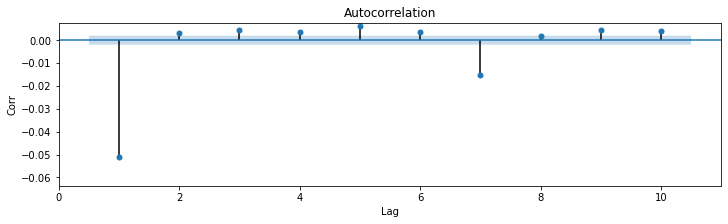

,lag,Ljung-Box Test p-val
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
5,6,0.0
6,7,0.0
7,8,0.0
8,9,0.0
9,10,0.0


In [8]:
path = next(Path('data_v2').rglob('PR_Card_2/*CVa2*/*cnt.bin'))
analyze_series(path)

### Card2 CVa4

**Strong correlations**, particularly between **two consecutive bits**.

INFO:TRNG Analysis:Doing data_v2/PR_Card_2/220928_CVa4/acq_20220928232412_cnt.bin


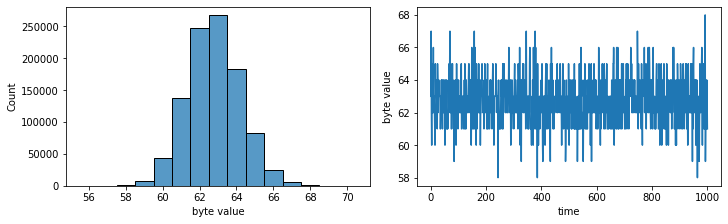

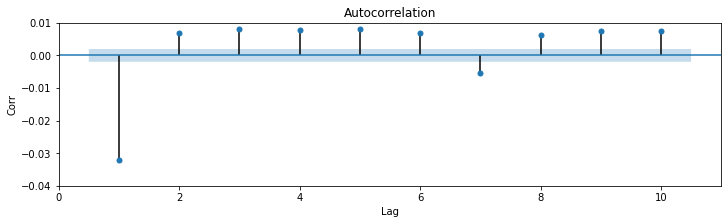

,lag,Ljung-Box Test p-val
0,1,5.417128e-225
1,2,5.470021e-234
2,3,1.765028e-246
3,4,8.746230e-259
4,5,2.894025e-271
5,6,7.454617e-280
6,7,7.982489e-285
7,8,1.866570e-292
8,9,1.706582e-303
9,10,0.000000e+00


In [9]:
path = next(Path('data_v2').rglob('PR_Card_2/*CVa4*/*cnt.bin'))
analyze_series(path)

### Card7 CVa1

**Strong correlations**, particularly between **two consecutive bits**.

INFO:TRNG Analysis:Doing data_v2/PR_Card_7/220928_CVa1/acq_20220928164154_cnt.bin


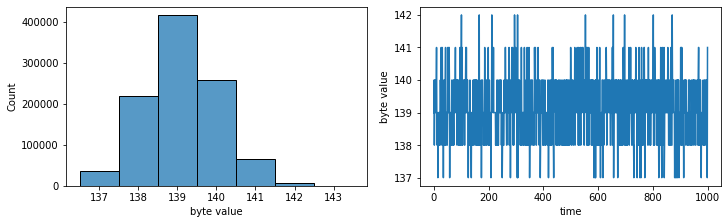

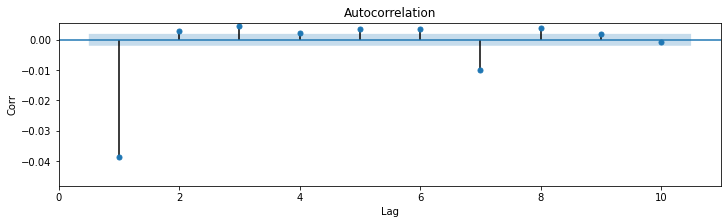

,lag,Ljung-Box Test p-val
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
5,6,0.0
6,7,0.0
7,8,0.0
8,9,0.0
9,10,0.0


In [10]:
path = next(Path('data_v2').rglob('PR_Card_7/*CVa1*/*cnt.bin'))
analyze_series(path)

### Card7 CVa2

**Strong correlations**, particularly between **two consecutive bits**.

INFO:TRNG Analysis:Doing data_v2/PR_Card_7/220928_CVa2/acq_20220928164817_cnt.bin


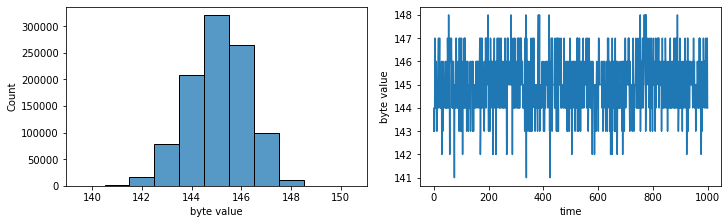

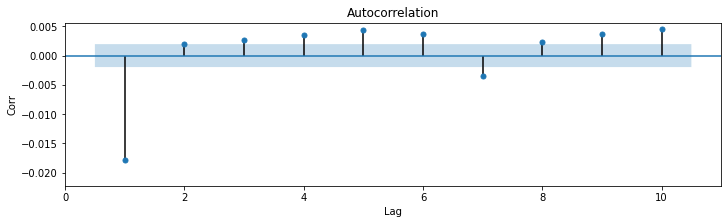

,lag,Ljung-Box Test p-val
0,1,6.795006e-71
1,2,1.909264e-70
2,3,8.500493e-71
3,4,2.682302e-72
4,5,1.910131e-75
5,6,2.139094e-77
6,7,5.156632e-79
7,8,2.320262e-79
8,9,2.798397e-81
9,10,1.008640e-84


In [11]:
path = next(Path('data_v2').rglob('PR_Card_7/*CVa2*/*cnt.bin'))
analyze_series(path)

### Card7 CVa4

**Strong correlations**, particularly between **two consecutive bits**.

INFO:TRNG Analysis:Doing data_v2/PR_Card_7/220928_CVa4/acq_20220928165458_cnt.bin


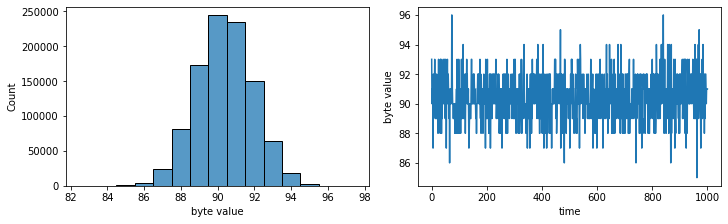

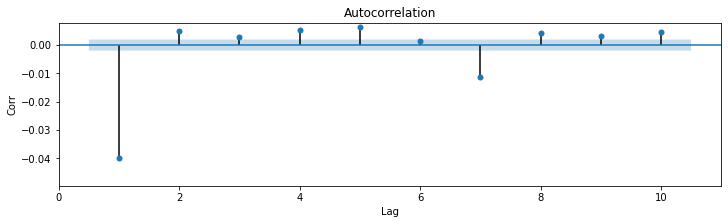

,lag,Ljung-Box Test p-val
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
5,6,0.0
6,7,0.0
7,8,0.0
8,9,0.0
9,10,0.0


In [12]:
path = next(Path('data_v2').rglob('PR_Card_7/*CVa4*/*cnt.bin'))
analyze_series(path)